In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
from PIL import Image
import torch
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import compute_roc_auc
from monai.networks.nets import densenet121, densenet201
from monai.transforms import (
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor
)
from monai.utils import set_determinism

#from data_split import data_separator, get_oversampling
#from data_loader import load_and_preprocess_image, generate_path_dataset, augmenter
#from model_creation import start_model, set_check_poin_saver, set_check_point_saver_regression
#from model_evaluation import plot_model_history, get_dataset_prediction, evaluate_prediction

2024-03-15 13:32:34.168349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 13:32:34.367635: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 13:32:35.186190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/12559743/.local/lib/python3.10/site-packages/cv2/../../lib64::/opt/Qt/6.3.1/gcc_6/lib:/opt/Qt/6.3.1/gcc_6/lib
2024-03-15 13:32:35.186363: W tensorflow/stream_executor/platform/default/dso_loader.cc:

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [3]:
df = pd.read_csv("/home/12559743/DAVI/IC/Codes/data_aug.csv")
print(len(df))

1455


In [5]:
print(df.iloc[1430]['Patient'], df.iloc[1430]['PAN Date'], df.iloc[1430]['PAN Path'])

nan nan /home/12559743/DAVI/todos_pacientes/ZILDA SCHIAVON CAMILLO/ZILDA SCHIAVON CAMILLO- -- - - - 15-09-1961- PX from 29-02-2016 S0 I0aug_cr.jpg


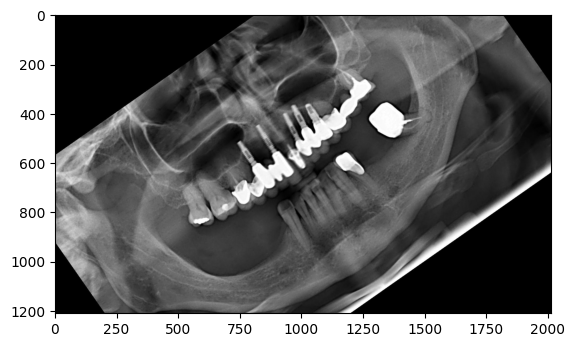

In [6]:
img = plt.imread(df.iloc[1450]['PAN Path'])
plt.imshow(img)

In [7]:
from sklearn.model_selection import train_test_split as splitter
import random

def data_separator(data, train_rate=0.70, val_rate=0.50, SEED=42):
    
    '''
        Applies train, val, test split.
    '''
    
    # Separando train, val and test IMAGE path list
    
    if not val_rate:
        train, test = splitter(data, test_size= 1-train_rate, shuffle=True, random_state=SEED)
        
        return train, test
        
    elif val_rate:
        train, test = splitter(data, test_size= 1-train_rate, shuffle=True, random_state=SEED)
        
        val, test = splitter(test, test_size= 1-val_rate, shuffle=True, random_state=SEED)

        return train, val, test 



In [8]:
train, val, test = data_separator(df, train_rate=.8, val_rate=.5)
    
print(len(train), len(val), len(test))

1164 145 146


In [9]:
train_list = (list(train['PAN Path']), list(train['Sex']))
val_list = (list(val['PAN Path']), list(val['Sex']))
test_list = (list(test['PAN Path']), list(test['Sex']))

print(len(train), len(val), len(test))

1164 145 146


In [10]:
image_list_train =[]
image_list_train_y = []

for i in range(len(train)):
    #print(i)
    x = cv2.imread(train_list[0][i])
    x = cv2.resize(x, (224, 224))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    image_list_train.append(x)
    image_list_train_y.append(train_list[1][i])
    
image_list_val = []
image_list_val_y = []

for i in range(len(val)):
    #print(i)
    x = cv2.imread(val_list[0][i])
    x = cv2.resize(x, (224, 224))
    X = cv2.cvtColor(x,  cv2.COLOR_BGR2RGB)
    image_list_val.append(x)
    image_list_val_y.append(val_list[1][i])
    
    
    
image_list_test = []
image_list_test_y = []

for i in range(len(test)):
    #print(i)
    x = cv2.imread(test_list[0][i])
    x = cv2.resize(x, (224, 224))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    image_list_test.append(x)
    image_list_test_y.append(test_list[1][i])

In [11]:
image_list_train_y = np.array(image_list_train_y)
image_list_val_y = np.array(image_list_val_y)
image_list_test_y = np.array(image_list_test_y)

In [12]:
image_list_test_y[7]

0

In [13]:
w, h , c= image_list_train[0].shape

In [14]:
image_list_train = np.array(image_list_train)
image_list_val = np.array(image_list_val)
image_list_test = np.array(image_list_test)

In [15]:
image_list_train = image_list_train.reshape((-1, w,h,3))
image_list_val = image_list_val.reshape((-1, w,h,3))
image_list_test = image_list_test.reshape((-1, w,h,3))

In [16]:
from torchvision import transforms

normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224,0.225 ])
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

image_list_train_tensor = torch.stack([transform(image) for image in image_list_train])
image_list_val_tensor = torch.stack([transform(image) for image in image_list_val])
image_list_test_tensor = torch.stack([transform(image) for image in image_list_test])

In [17]:
image_list_train_tensor.shape

torch.Size([1164, 3, 224, 224])

In [18]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, labels = None, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx] if self.labels is not None else None
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
def transform_image(image):
    image = torch.tensor(image, dtype=torch.float32)
    
    image = image / 255.0
    return image

dataset = CustomDataset(image_list_train, image_list_train_y, transform = transform_image)

In [19]:
batch_size = 16

train_ds = CustomDataset(image_list_train_tensor, image_list_train_y, transform_image)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

val_ds = CustomDataset(image_list_val_tensor, image_list_val_y, transform_image)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=4)

test_ds = CustomDataset(image_list_test_tensor, image_list_test_y, transform_image)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

In [26]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_v2_s
import timm

'''
Construir primeira camada de rede neural com pesos iguais
'''
class MyModel(nn.Module):
    def __init__(self, drop_prob = 0.2):
        super(MyModel, self).__init__()
        
        self.efficientnet = efficientnet_v2_s(weights='DEFAULT')
        
        for param in self.efficientnet.parameters():
            param.requires_grad = True
        
        
        num_ftrs = self.efficientnet.classifier[-1].in_features
        
        self.efficientnet.classifier[-1] = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs, 64)
        self.dropout1 = nn.Dropout(drop_prob)
        self.fc2 = nn.Linear(64, 16)
        self.dropout2 = nn.Dropout(drop_prob)
        self.fc3 = nn.Linear(16,1)
        
    def forward(self, x):
        x = self.efficientnet(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        
        return x
    
    
    
drop_prob = 0.2
model = MyModel(drop_prob)

In [21]:
class Complexity:
    def __init__(self):
        self.bins = 100

    def entropy(self, p):
        histogram = torch.histc(p.detach(), bins=self.bins)
        prob = histogram
        log_prob = histogram.log()
        plogp = prob*log_prob
        plogp[torch.isnan(plogp)] = 0
        return plogp.sum().detach().cpu().numpy()

    def desiquilibrium(self, p):
        histogram = torch.histc(p.detach(), bins=self.bins)
        histogram = histogram - self.normal_prob()
        return histogram.square().sum().cpu().numpy()

    def complexity(self, p):
        return self.entropy(p) * self.desiquilibrium(p)


    def normal_prob(self):
        return 1.0/self.bins

def extract_model_data(model, model_data=None):
    if model_data is None:
        model_data = dict()
    c = Complexity()
    for name, param in model.named_parameters():
        if param.requires_grad:
            # we got a valid parameter to extract
            if name not in model_data.keys():
                model_data[name] = {'entropy' : list(), 'desiquilibrium' : list(), 'complexity' : list() }
            model_data[name]['entropy'].append(c.entropy(param.data))
            model_data[name]['desiquilibrium'].append(c.desiquilibrium(param.data))
            model_data[name]['complexity'].append(c.complexity(param.data))
    return model_data

In [23]:
loss_function = torch.nn.BCELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), 1e-4)


In [24]:
import tempfile
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpzifqyu9q


In [27]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

max_epochs = 50
val_interval = 1


model.to(device)


model_data = None
single_complexity = list()
single_loss = list()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze(dim=1)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

        # EXTRACT MODEL DATA
        model_data = extract_model_data(model, model_data)
        myp = torch.nn.utils.parameters_to_vector(model.parameters())
        single_complexity.append(Complexity().complexity(myp))
        single_loss.append(loss.item())

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            auc_metric = compute_roc_auc(
                y_pred, y)
            metric_values.append(auc_metric)
            '''
            y_one_hot = label_binarize(y.cpu().numpy(), classes=np.arange(num_classes))
            fpr, tpr, _ = roc_curve(y_one_hot.ravel(), y_pred.cpu().numpy().ravel())
            auc_value = auc(fpr, tpr)
            '''
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6871
2/72, train_loss: 0.6956
3/72, train_loss: 0.6963
4/72, train_loss: 0.6929
5/72, train_loss: 0.6899
6/72, train_loss: 0.6921
7/72, train_loss: 0.6927
8/72, train_loss: 0.6934
9/72, train_loss: 0.6955
10/72, train_loss: 0.6906
11/72, train_loss: 0.6938
12/72, train_loss: 0.6948
13/72, train_loss: 0.6914
14/72, train_loss: 0.6865
15/72, train_loss: 0.6945
16/72, train_loss: 0.6948
17/72, train_loss: 0.6943
18/72, train_loss: 0.6855
19/72, train_loss: 0.6894
20/72, train_loss: 0.6978
21/72, train_loss: 0.6918
22/72, train_loss: 0.6952
23/72, train_loss: 0.6919
24/72, train_loss: 0.6975
25/72, train_loss: 0.6963
26/72, train_loss: 0.6903
27/72, train_loss: 0.6879
28/72, train_loss: 0.6880
29/72, train_loss: 0.6927
30/72, train_loss: 0.6932
31/72, train_loss: 0.6939
32/72, train_loss: 0.6941
33/72, train_loss: 0.6891
34/72, train_loss: 0.6882
35/72, train_loss: 0.6909
36/72, train_loss: 0.6997
37/72, train_loss: 0.6916
38/72, train_loss: 0.6907
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 1 current AUC: 0.5129 current accuracy: 0.6000 best AUC: 0.5129 at epoch: 1
----------
epoch 2/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6900
2/72, train_loss: 0.6978
3/72, train_loss: 0.6940
4/72, train_loss: 0.6955
5/72, train_loss: 0.7009
6/72, train_loss: 0.6952
7/72, train_loss: 0.6928
8/72, train_loss: 0.6888
9/72, train_loss: 0.6955
10/72, train_loss: 0.6916
11/72, train_loss: 0.6945
12/72, train_loss: 0.6951
13/72, train_loss: 0.6922
14/72, train_loss: 0.6911
15/72, train_loss: 0.6884
16/72, train_loss: 0.6946
17/72, train_loss: 0.6930
18/72, train_loss: 0.6879
19/72, train_loss: 0.6900
20/72, train_loss: 0.6954
21/72, train_loss: 0.6943
22/72, train_loss: 0.6896
23/72, train_loss: 0.6900
24/72, train_loss: 0.6933
25/72, train_loss: 0.6942
26/72, train_loss: 0.6891
27/72, train_loss: 0.6929
28/72, train_loss: 0.6961
29/72, train_loss: 0.6904
30/72, train_loss: 0.6953
31/72, train_loss: 0.6907
32/72, train_loss: 0.6935
33/72, train_loss: 0.6953
34/72, train_loss: 0.6933
35/72, train_loss: 0.6895
36/72, train_loss: 0.6930
37/72, train_loss: 0.6931
38/72, train_loss: 0.6929
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 2 current AUC: 0.6159 current accuracy: 0.6000 best AUC: 0.6159 at epoch: 2
----------
epoch 3/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6938
2/72, train_loss: 0.6893
3/72, train_loss: 0.6885
4/72, train_loss: 0.6926
5/72, train_loss: 0.6866
6/72, train_loss: 0.6954
7/72, train_loss: 0.6920
8/72, train_loss: 0.6913
9/72, train_loss: 0.6896
10/72, train_loss: 0.6873
11/72, train_loss: 0.6904
12/72, train_loss: 0.6922
13/72, train_loss: 0.6950
14/72, train_loss: 0.6902
15/72, train_loss: 0.6989
16/72, train_loss: 0.6901
17/72, train_loss: 0.6878
18/72, train_loss: 0.6921
19/72, train_loss: 0.6964
20/72, train_loss: 0.6972
21/72, train_loss: 0.6903
22/72, train_loss: 0.6926
23/72, train_loss: 0.6907
24/72, train_loss: 0.6901
25/72, train_loss: 0.6925
26/72, train_loss: 0.6904
27/72, train_loss: 0.6921
28/72, train_loss: 0.6852
29/72, train_loss: 0.6911
30/72, train_loss: 0.6938
31/72, train_loss: 0.6946
32/72, train_loss: 0.6933
33/72, train_loss: 0.6900
34/72, train_loss: 0.6976
35/72, train_loss: 0.6957
36/72, train_loss: 0.6969
37/72, train_loss: 0.6937
38/72, train_loss: 0.6933
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 3 current AUC: 0.5931 current accuracy: 0.6000 best AUC: 0.6159 at epoch: 2
----------
epoch 4/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6959
2/72, train_loss: 0.6950
3/72, train_loss: 0.6902
4/72, train_loss: 0.6987
5/72, train_loss: 0.6917
6/72, train_loss: 0.6922
7/72, train_loss: 0.6998
8/72, train_loss: 0.6875
9/72, train_loss: 0.6966
10/72, train_loss: 0.6917
11/72, train_loss: 0.6902
12/72, train_loss: 0.6931
13/72, train_loss: 0.6941
14/72, train_loss: 0.6968
15/72, train_loss: 0.6961
16/72, train_loss: 0.6906
17/72, train_loss: 0.6886
18/72, train_loss: 0.6941
19/72, train_loss: 0.6937
20/72, train_loss: 0.6884
21/72, train_loss: 0.6887
22/72, train_loss: 0.6996
23/72, train_loss: 0.6958
24/72, train_loss: 0.6961
25/72, train_loss: 0.6890
26/72, train_loss: 0.6931
27/72, train_loss: 0.6915
28/72, train_loss: 0.6938
29/72, train_loss: 0.7001
30/72, train_loss: 0.6905
31/72, train_loss: 0.6869
32/72, train_loss: 0.6900
33/72, train_loss: 0.6938
34/72, train_loss: 0.6931
35/72, train_loss: 0.6917
36/72, train_loss: 0.6877
37/72, train_loss: 0.6950
38/72, train_loss: 0.6938
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 4 current AUC: 0.5866 current accuracy: 0.6000 best AUC: 0.6159 at epoch: 2
----------
epoch 5/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6921
2/72, train_loss: 0.6920
3/72, train_loss: 0.6933
4/72, train_loss: 0.6961
5/72, train_loss: 0.6925
6/72, train_loss: 0.6962
7/72, train_loss: 0.6889
8/72, train_loss: 0.6881
9/72, train_loss: 0.6880
10/72, train_loss: 0.6918
11/72, train_loss: 0.6934
12/72, train_loss: 0.6885
13/72, train_loss: 0.6888
14/72, train_loss: 0.6911
15/72, train_loss: 0.6898
16/72, train_loss: 0.6926
17/72, train_loss: 0.6934
18/72, train_loss: 0.6933
19/72, train_loss: 0.6971
20/72, train_loss: 0.6935
21/72, train_loss: 0.6918
22/72, train_loss: 0.6893
23/72, train_loss: 0.6946
24/72, train_loss: 0.6959
25/72, train_loss: 0.6897
26/72, train_loss: 0.6937
27/72, train_loss: 0.6939
28/72, train_loss: 0.6921
29/72, train_loss: 0.7003
30/72, train_loss: 0.6925
31/72, train_loss: 0.6906
32/72, train_loss: 0.6914
33/72, train_loss: 0.6968
34/72, train_loss: 0.6984
35/72, train_loss: 0.6912
36/72, train_loss: 0.6875
37/72, train_loss: 0.6918
38/72, train_loss: 0.6883
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 5 current AUC: 0.5991 current accuracy: 0.6000 best AUC: 0.6159 at epoch: 2
----------
epoch 6/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6950
2/72, train_loss: 0.6903
3/72, train_loss: 0.6922
4/72, train_loss: 0.6921
5/72, train_loss: 0.6918
6/72, train_loss: 0.6928
7/72, train_loss: 0.6943
8/72, train_loss: 0.6895
9/72, train_loss: 0.6911
10/72, train_loss: 0.6934
11/72, train_loss: 0.6899
12/72, train_loss: 0.6899
13/72, train_loss: 0.6915
14/72, train_loss: 0.6954
15/72, train_loss: 0.6941
16/72, train_loss: 0.6913
17/72, train_loss: 0.6909
18/72, train_loss: 0.6893
19/72, train_loss: 0.6942
20/72, train_loss: 0.6898
21/72, train_loss: 0.6858
22/72, train_loss: 0.6955
23/72, train_loss: 0.6961
24/72, train_loss: 0.6913
25/72, train_loss: 0.6950
26/72, train_loss: 0.6940
27/72, train_loss: 0.6951
28/72, train_loss: 0.6947
29/72, train_loss: 0.6903
30/72, train_loss: 0.6906
31/72, train_loss: 0.6840
32/72, train_loss: 0.6981
33/72, train_loss: 0.6882
34/72, train_loss: 0.6947
35/72, train_loss: 0.6929
36/72, train_loss: 0.6918
37/72, train_loss: 0.6897
38/72, train_loss: 0.7003
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 6 current AUC: 0.6306 current accuracy: 0.6000 best AUC: 0.6306 at epoch: 6
----------
epoch 7/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6916
2/72, train_loss: 0.6940
3/72, train_loss: 0.6967
4/72, train_loss: 0.6930
5/72, train_loss: 0.6941
6/72, train_loss: 0.6887
7/72, train_loss: 0.6939
8/72, train_loss: 0.6921
9/72, train_loss: 0.6858
10/72, train_loss: 0.6911
11/72, train_loss: 0.6885
12/72, train_loss: 0.6942
13/72, train_loss: 0.6857
14/72, train_loss: 0.6927
15/72, train_loss: 0.6919
16/72, train_loss: 0.6980
17/72, train_loss: 0.6988
18/72, train_loss: 0.6914
19/72, train_loss: 0.6880
20/72, train_loss: 0.6908
21/72, train_loss: 0.6950
22/72, train_loss: 0.6923
23/72, train_loss: 0.6883
24/72, train_loss: 0.6946
25/72, train_loss: 0.6918
26/72, train_loss: 0.6934
27/72, train_loss: 0.6900
28/72, train_loss: 0.6856
29/72, train_loss: 0.6931
30/72, train_loss: 0.6864
31/72, train_loss: 0.6919
32/72, train_loss: 0.6961
33/72, train_loss: 0.6921
34/72, train_loss: 0.6908
35/72, train_loss: 0.6926
36/72, train_loss: 0.6928
37/72, train_loss: 0.6869
38/72, train_loss: 0.6996
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 7 current AUC: 0.4893 current accuracy: 0.6000 best AUC: 0.6306 at epoch: 6
----------
epoch 8/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6846
2/72, train_loss: 0.6897
3/72, train_loss: 0.6938
4/72, train_loss: 0.6943
5/72, train_loss: 0.6939
6/72, train_loss: 0.6957
7/72, train_loss: 0.6906
8/72, train_loss: 0.6835
9/72, train_loss: 0.6977
10/72, train_loss: 0.6978
11/72, train_loss: 0.6931
12/72, train_loss: 0.6931
13/72, train_loss: 0.6911
14/72, train_loss: 0.6947
15/72, train_loss: 0.6937
16/72, train_loss: 0.6977
17/72, train_loss: 0.6878
18/72, train_loss: 0.6966
19/72, train_loss: 0.6941
20/72, train_loss: 0.6934
21/72, train_loss: 0.6977
22/72, train_loss: 0.6938
23/72, train_loss: 0.6918
24/72, train_loss: 0.6968
25/72, train_loss: 0.6951
26/72, train_loss: 0.6936
27/72, train_loss: 0.6928
28/72, train_loss: 0.6915
29/72, train_loss: 0.6916
30/72, train_loss: 0.6988
31/72, train_loss: 0.6944
32/72, train_loss: 0.6936
33/72, train_loss: 0.6938
34/72, train_loss: 0.6989
35/72, train_loss: 0.6914
36/72, train_loss: 0.6948
37/72, train_loss: 0.6985
38/72, train_loss: 0.6893
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 8 current AUC: 0.6177 current accuracy: 0.6000 best AUC: 0.6306 at epoch: 6
----------
epoch 9/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6883
2/72, train_loss: 0.6932
3/72, train_loss: 0.6970
4/72, train_loss: 0.6931
5/72, train_loss: 0.6964
6/72, train_loss: 0.6943
7/72, train_loss: 0.6941
8/72, train_loss: 0.6950
9/72, train_loss: 0.6937
10/72, train_loss: 0.6947
11/72, train_loss: 0.6905
12/72, train_loss: 0.6940
13/72, train_loss: 0.6971
14/72, train_loss: 0.6966
15/72, train_loss: 0.6925
16/72, train_loss: 0.6963
17/72, train_loss: 0.6917
18/72, train_loss: 0.6939
19/72, train_loss: 0.6925
20/72, train_loss: 0.6877
21/72, train_loss: 0.6960
22/72, train_loss: 0.6940
23/72, train_loss: 0.6940
24/72, train_loss: 0.6909
25/72, train_loss: 0.6902
26/72, train_loss: 0.6953
27/72, train_loss: 0.6947
28/72, train_loss: 0.6965
29/72, train_loss: 0.6955
30/72, train_loss: 0.6984
31/72, train_loss: 0.6915
32/72, train_loss: 0.6957
33/72, train_loss: 0.6909
34/72, train_loss: 0.6915
35/72, train_loss: 0.6845
36/72, train_loss: 0.6946
37/72, train_loss: 0.6956
38/72, train_loss: 0.6923
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 9 current AUC: 0.5900 current accuracy: 0.6000 best AUC: 0.6306 at epoch: 6
----------
epoch 10/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6899
2/72, train_loss: 0.6928
3/72, train_loss: 0.6965
4/72, train_loss: 0.6901
5/72, train_loss: 0.6918
6/72, train_loss: 0.6864
7/72, train_loss: 0.6907
8/72, train_loss: 0.6920
9/72, train_loss: 0.6927
10/72, train_loss: 0.6889
11/72, train_loss: 0.6902
12/72, train_loss: 0.6965
13/72, train_loss: 0.6990
14/72, train_loss: 0.6889
15/72, train_loss: 0.6911
16/72, train_loss: 0.6952
17/72, train_loss: 0.6866
18/72, train_loss: 0.6895
19/72, train_loss: 0.6873
20/72, train_loss: 0.6923
21/72, train_loss: 0.6941
22/72, train_loss: 0.6927
23/72, train_loss: 0.6870
24/72, train_loss: 0.6938
25/72, train_loss: 0.6941
26/72, train_loss: 0.6928
27/72, train_loss: 0.6887
28/72, train_loss: 0.6969
29/72, train_loss: 0.6934
30/72, train_loss: 0.6902
31/72, train_loss: 0.6891
32/72, train_loss: 0.6906
33/72, train_loss: 0.6868
34/72, train_loss: 0.6910
35/72, train_loss: 0.6905
36/72, train_loss: 0.6933
37/72, train_loss: 0.6952
38/72, train_loss: 0.6943
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 10 current AUC: 0.5585 current accuracy: 0.6000 best AUC: 0.6306 at epoch: 6
----------
epoch 11/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6828
2/72, train_loss: 0.6937
3/72, train_loss: 0.6918
4/72, train_loss: 0.6898
5/72, train_loss: 0.6967
6/72, train_loss: 0.6885
7/72, train_loss: 0.6914
8/72, train_loss: 0.6880
9/72, train_loss: 0.6872
10/72, train_loss: 0.6948
11/72, train_loss: 0.6944
12/72, train_loss: 0.6920
13/72, train_loss: 0.6892
14/72, train_loss: 0.6902
15/72, train_loss: 0.6942
16/72, train_loss: 0.6940
17/72, train_loss: 0.6901
18/72, train_loss: 0.6904
19/72, train_loss: 0.6962
20/72, train_loss: 0.6916
21/72, train_loss: 0.6908
22/72, train_loss: 0.6913
23/72, train_loss: 0.6939
24/72, train_loss: 0.6943
25/72, train_loss: 0.6915
26/72, train_loss: 0.6901
27/72, train_loss: 0.6897
28/72, train_loss: 0.6861
29/72, train_loss: 0.6947
30/72, train_loss: 0.6890
31/72, train_loss: 0.6927
32/72, train_loss: 0.6926
33/72, train_loss: 0.6959
34/72, train_loss: 0.7004
35/72, train_loss: 0.6946
36/72, train_loss: 0.6935
37/72, train_loss: 0.6978
38/72, train_loss: 0.6935
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 11 current AUC: 0.6411 current accuracy: 0.6000 best AUC: 0.6411 at epoch: 11
----------
epoch 12/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6957
2/72, train_loss: 0.6918
3/72, train_loss: 0.6923
4/72, train_loss: 0.6930
5/72, train_loss: 0.6890
6/72, train_loss: 0.6939
7/72, train_loss: 0.6914
8/72, train_loss: 0.6899
9/72, train_loss: 0.6896
10/72, train_loss: 0.6970
11/72, train_loss: 0.6981
12/72, train_loss: 0.6899
13/72, train_loss: 0.6907
14/72, train_loss: 0.6919
15/72, train_loss: 0.6888
16/72, train_loss: 0.6928
17/72, train_loss: 0.6954
18/72, train_loss: 0.6899
19/72, train_loss: 0.6972
20/72, train_loss: 0.6936
21/72, train_loss: 0.6928
22/72, train_loss: 0.6916
23/72, train_loss: 0.6955
24/72, train_loss: 0.6899
25/72, train_loss: 0.6945
26/72, train_loss: 0.6927
27/72, train_loss: 0.6973
28/72, train_loss: 0.6965
29/72, train_loss: 0.6922
30/72, train_loss: 0.7051
31/72, train_loss: 0.6941
32/72, train_loss: 0.6891
33/72, train_loss: 0.6978
34/72, train_loss: 0.6980
35/72, train_loss: 0.6958
36/72, train_loss: 0.6959
37/72, train_loss: 0.6953
38/72, train_loss: 0.6924
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 12 current AUC: 0.6591 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 13/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6923
2/72, train_loss: 0.6915
3/72, train_loss: 0.6957
4/72, train_loss: 0.6932
5/72, train_loss: 0.6920
6/72, train_loss: 0.6893
7/72, train_loss: 0.6987
8/72, train_loss: 0.6892
9/72, train_loss: 0.6949
10/72, train_loss: 0.6939
11/72, train_loss: 0.6958
12/72, train_loss: 0.6917
13/72, train_loss: 0.6934
14/72, train_loss: 0.6918
15/72, train_loss: 0.6906
16/72, train_loss: 0.6925
17/72, train_loss: 0.6900
18/72, train_loss: 0.6928
19/72, train_loss: 0.6937
20/72, train_loss: 0.6920
21/72, train_loss: 0.6914
22/72, train_loss: 0.6877
23/72, train_loss: 0.6931
24/72, train_loss: 0.6925
25/72, train_loss: 0.6891
26/72, train_loss: 0.6939
27/72, train_loss: 0.6885
28/72, train_loss: 0.6908
29/72, train_loss: 0.6975
30/72, train_loss: 0.6934
31/72, train_loss: 0.6899
32/72, train_loss: 0.6922
33/72, train_loss: 0.6890
34/72, train_loss: 0.6959
35/72, train_loss: 0.6939
36/72, train_loss: 0.6988
37/72, train_loss: 0.6910
38/72, train_loss: 0.6899
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 13 current AUC: 0.6459 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 14/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6920
2/72, train_loss: 0.6917
3/72, train_loss: 0.7003
4/72, train_loss: 0.6896
5/72, train_loss: 0.6944
6/72, train_loss: 0.6911
7/72, train_loss: 0.6956
8/72, train_loss: 0.6876
9/72, train_loss: 0.6892
10/72, train_loss: 0.6922
11/72, train_loss: 0.6943
12/72, train_loss: 0.6964
13/72, train_loss: 0.6935
14/72, train_loss: 0.6906
15/72, train_loss: 0.6954
16/72, train_loss: 0.7011
17/72, train_loss: 0.6930
18/72, train_loss: 0.6875
19/72, train_loss: 0.6920
20/72, train_loss: 0.6994
21/72, train_loss: 0.6936
22/72, train_loss: 0.6878
23/72, train_loss: 0.6906
24/72, train_loss: 0.6940
25/72, train_loss: 0.6927
26/72, train_loss: 0.6849
27/72, train_loss: 0.6870
28/72, train_loss: 0.6958
29/72, train_loss: 0.6918
30/72, train_loss: 0.6907
31/72, train_loss: 0.6895
32/72, train_loss: 0.6890
33/72, train_loss: 0.6868
34/72, train_loss: 0.6873
35/72, train_loss: 0.6920
36/72, train_loss: 0.6940
37/72, train_loss: 0.6894
38/72, train_loss: 0.6922
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 14 current AUC: 0.5878 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 15/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6931
2/72, train_loss: 0.6921
3/72, train_loss: 0.6903
4/72, train_loss: 0.6925
5/72, train_loss: 0.6914
6/72, train_loss: 0.6933
7/72, train_loss: 0.6887
8/72, train_loss: 0.6903
9/72, train_loss: 0.6920
10/72, train_loss: 0.7000
11/72, train_loss: 0.6969
12/72, train_loss: 0.6955
13/72, train_loss: 0.6938
14/72, train_loss: 0.6961
15/72, train_loss: 0.6889
16/72, train_loss: 0.6937
17/72, train_loss: 0.6944
18/72, train_loss: 0.6886
19/72, train_loss: 0.6912
20/72, train_loss: 0.6918
21/72, train_loss: 0.6937
22/72, train_loss: 0.6974
23/72, train_loss: 0.6977
24/72, train_loss: 0.6977
25/72, train_loss: 0.6899
26/72, train_loss: 0.6972
27/72, train_loss: 0.6945
28/72, train_loss: 0.6922
29/72, train_loss: 0.6904
30/72, train_loss: 0.6941
31/72, train_loss: 0.6980
32/72, train_loss: 0.6900
33/72, train_loss: 0.6979
34/72, train_loss: 0.6923
35/72, train_loss: 0.6938
36/72, train_loss: 0.6966
37/72, train_loss: 0.6939
38/72, train_loss: 0.6898
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 15 current AUC: 0.6320 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 16/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6914
2/72, train_loss: 0.6984
3/72, train_loss: 0.6875
4/72, train_loss: 0.6930
5/72, train_loss: 0.6934
6/72, train_loss: 0.6878
7/72, train_loss: 0.6884
8/72, train_loss: 0.6895
9/72, train_loss: 0.6895
10/72, train_loss: 0.6979
11/72, train_loss: 0.6963
12/72, train_loss: 0.6919
13/72, train_loss: 0.6925
14/72, train_loss: 0.6914
15/72, train_loss: 0.6947
16/72, train_loss: 0.6925
17/72, train_loss: 0.6938
18/72, train_loss: 0.6950
19/72, train_loss: 0.6959
20/72, train_loss: 0.6935
21/72, train_loss: 0.6985
22/72, train_loss: 0.6929
23/72, train_loss: 0.6945
24/72, train_loss: 0.6915
25/72, train_loss: 0.6902
26/72, train_loss: 0.6895
27/72, train_loss: 0.6866
28/72, train_loss: 0.6934
29/72, train_loss: 0.6952
30/72, train_loss: 0.6939
31/72, train_loss: 0.6961
32/72, train_loss: 0.6861
33/72, train_loss: 0.6902
34/72, train_loss: 0.6933
35/72, train_loss: 0.6891
36/72, train_loss: 0.6933
37/72, train_loss: 0.6922
38/72, train_loss: 0.6914
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 16 current AUC: 0.6247 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 17/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6973
2/72, train_loss: 0.6915
3/72, train_loss: 0.6874
4/72, train_loss: 0.6969
5/72, train_loss: 0.6927
6/72, train_loss: 0.6945
7/72, train_loss: 0.6898
8/72, train_loss: 0.6906
9/72, train_loss: 0.6958
10/72, train_loss: 0.6914
11/72, train_loss: 0.6910
12/72, train_loss: 0.6882
13/72, train_loss: 0.6980
14/72, train_loss: 0.6880
15/72, train_loss: 0.6932
16/72, train_loss: 0.6939
17/72, train_loss: 0.6854
18/72, train_loss: 0.6987
19/72, train_loss: 0.6990
20/72, train_loss: 0.6966
21/72, train_loss: 0.6915
22/72, train_loss: 0.6880
23/72, train_loss: 0.6925
24/72, train_loss: 0.6933
25/72, train_loss: 0.6918
26/72, train_loss: 0.6946
27/72, train_loss: 0.6852
28/72, train_loss: 0.6960
29/72, train_loss: 0.6954
30/72, train_loss: 0.6906
31/72, train_loss: 0.6894
32/72, train_loss: 0.6921
33/72, train_loss: 0.6907
34/72, train_loss: 0.6939
35/72, train_loss: 0.6917
36/72, train_loss: 0.6904
37/72, train_loss: 0.6959
38/72, train_loss: 0.6845
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 17 current AUC: 0.5815 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 18/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6929
2/72, train_loss: 0.6919
3/72, train_loss: 0.7017
4/72, train_loss: 0.6952
5/72, train_loss: 0.6915
6/72, train_loss: 0.6906
7/72, train_loss: 0.6859
8/72, train_loss: 0.6901
9/72, train_loss: 0.6964
10/72, train_loss: 0.6924
11/72, train_loss: 0.6898
12/72, train_loss: 0.6911
13/72, train_loss: 0.6902
14/72, train_loss: 0.6920
15/72, train_loss: 0.6946
16/72, train_loss: 0.6925
17/72, train_loss: 0.6930
18/72, train_loss: 0.6957
19/72, train_loss: 0.6955
20/72, train_loss: 0.6848
21/72, train_loss: 0.6864
22/72, train_loss: 0.6909
23/72, train_loss: 0.6915
24/72, train_loss: 0.6978
25/72, train_loss: 0.6944
26/72, train_loss: 0.6878
27/72, train_loss: 0.6939
28/72, train_loss: 0.6898
29/72, train_loss: 0.6937
30/72, train_loss: 0.6941
31/72, train_loss: 0.6974
32/72, train_loss: 0.6974
33/72, train_loss: 0.6945
34/72, train_loss: 0.6938
35/72, train_loss: 0.6911
36/72, train_loss: 0.6928
37/72, train_loss: 0.6869
38/72, train_loss: 0.6908
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 18 current AUC: 0.6149 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 19/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6889
2/72, train_loss: 0.6947
3/72, train_loss: 0.6874
4/72, train_loss: 0.6965
5/72, train_loss: 0.6923
6/72, train_loss: 0.6917
7/72, train_loss: 0.6929
8/72, train_loss: 0.6932
9/72, train_loss: 0.6985
10/72, train_loss: 0.6889
11/72, train_loss: 0.6851
12/72, train_loss: 0.6898
13/72, train_loss: 0.6900
14/72, train_loss: 0.6955
15/72, train_loss: 0.6923
16/72, train_loss: 0.6940
17/72, train_loss: 0.6949
18/72, train_loss: 0.6951
19/72, train_loss: 0.6906
20/72, train_loss: 0.6914
21/72, train_loss: 0.6940
22/72, train_loss: 0.6923
23/72, train_loss: 0.6891
24/72, train_loss: 0.6886
25/72, train_loss: 0.6947
26/72, train_loss: 0.6994
27/72, train_loss: 0.7004
28/72, train_loss: 0.6914
29/72, train_loss: 0.6981
30/72, train_loss: 0.6966
31/72, train_loss: 0.6949
32/72, train_loss: 0.6929
33/72, train_loss: 0.6941
34/72, train_loss: 0.7006
35/72, train_loss: 0.6932
36/72, train_loss: 0.6960
37/72, train_loss: 0.6904
38/72, train_loss: 0.6941
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 19 current AUC: 0.6223 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 20/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6887
2/72, train_loss: 0.6897
3/72, train_loss: 0.6962
4/72, train_loss: 0.6954
5/72, train_loss: 0.6972
6/72, train_loss: 0.6907
7/72, train_loss: 0.6904
8/72, train_loss: 0.6904
9/72, train_loss: 0.6908
10/72, train_loss: 0.6962
11/72, train_loss: 0.6926
12/72, train_loss: 0.6897
13/72, train_loss: 0.6892
14/72, train_loss: 0.6929
15/72, train_loss: 0.6878
16/72, train_loss: 0.6918
17/72, train_loss: 0.6953
18/72, train_loss: 0.6906
19/72, train_loss: 0.6961
20/72, train_loss: 0.6875
21/72, train_loss: 0.6955
22/72, train_loss: 0.6885
23/72, train_loss: 0.6910
24/72, train_loss: 0.6947
25/72, train_loss: 0.6895
26/72, train_loss: 0.6917
27/72, train_loss: 0.7012
28/72, train_loss: 0.6922
29/72, train_loss: 0.6899
30/72, train_loss: 0.6893
31/72, train_loss: 0.6897
32/72, train_loss: 0.6932
33/72, train_loss: 0.6896
34/72, train_loss: 0.6951
35/72, train_loss: 0.6923
36/72, train_loss: 0.6905
37/72, train_loss: 0.6949
38/72, train_loss: 0.6867
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 20 current AUC: 0.5698 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 21/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6886
2/72, train_loss: 0.6970
3/72, train_loss: 0.6932
4/72, train_loss: 0.6942
5/72, train_loss: 0.6937
6/72, train_loss: 0.6975
7/72, train_loss: 0.6920
8/72, train_loss: 0.6920
9/72, train_loss: 0.6905
10/72, train_loss: 0.6925
11/72, train_loss: 0.6924
12/72, train_loss: 0.6942
13/72, train_loss: 0.6866
14/72, train_loss: 0.6899
15/72, train_loss: 0.6949
16/72, train_loss: 0.6946
17/72, train_loss: 0.6976
18/72, train_loss: 0.6891
19/72, train_loss: 0.6906
20/72, train_loss: 0.6909
21/72, train_loss: 0.6929
22/72, train_loss: 0.6929
23/72, train_loss: 0.6971
24/72, train_loss: 0.6913
25/72, train_loss: 0.6935
26/72, train_loss: 0.6911
27/72, train_loss: 0.6851
28/72, train_loss: 0.6888
29/72, train_loss: 0.6863
30/72, train_loss: 0.6950
31/72, train_loss: 0.6918
32/72, train_loss: 0.6899
33/72, train_loss: 0.6879
34/72, train_loss: 0.6922
35/72, train_loss: 0.6889
36/72, train_loss: 0.6880
37/72, train_loss: 0.6972
38/72, train_loss: 0.6889
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 21 current AUC: 0.6459 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 22/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6970
2/72, train_loss: 0.6930
3/72, train_loss: 0.6909
4/72, train_loss: 0.6991
5/72, train_loss: 0.6934
6/72, train_loss: 0.6868
7/72, train_loss: 0.6881
8/72, train_loss: 0.6967
9/72, train_loss: 0.6953
10/72, train_loss: 0.6911
11/72, train_loss: 0.6870
12/72, train_loss: 0.6922
13/72, train_loss: 0.6970
14/72, train_loss: 0.6965
15/72, train_loss: 0.6961
16/72, train_loss: 0.6931
17/72, train_loss: 0.6949
18/72, train_loss: 0.6938
19/72, train_loss: 0.6888
20/72, train_loss: 0.6888
21/72, train_loss: 0.6931
22/72, train_loss: 0.6957
23/72, train_loss: 0.6956
24/72, train_loss: 0.6951
25/72, train_loss: 0.6929
26/72, train_loss: 0.7024
27/72, train_loss: 0.6938
28/72, train_loss: 0.6904
29/72, train_loss: 0.6890
30/72, train_loss: 0.6920
31/72, train_loss: 0.6970
32/72, train_loss: 0.6953
33/72, train_loss: 0.6902
34/72, train_loss: 0.6946
35/72, train_loss: 0.6904
36/72, train_loss: 0.6922
37/72, train_loss: 0.6903
38/72, train_loss: 0.6900
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 22 current AUC: 0.5591 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 23/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6932
2/72, train_loss: 0.6874
3/72, train_loss: 0.6888
4/72, train_loss: 0.6970
5/72, train_loss: 0.6962
6/72, train_loss: 0.6945
7/72, train_loss: 0.6920
8/72, train_loss: 0.6974
9/72, train_loss: 0.6878
10/72, train_loss: 0.6918
11/72, train_loss: 0.6928
12/72, train_loss: 0.6947
13/72, train_loss: 0.7007
14/72, train_loss: 0.6930
15/72, train_loss: 0.6916
16/72, train_loss: 0.6940
17/72, train_loss: 0.6975
18/72, train_loss: 0.6940
19/72, train_loss: 0.6885
20/72, train_loss: 0.6923
21/72, train_loss: 0.6988
22/72, train_loss: 0.6942
23/72, train_loss: 0.6909
24/72, train_loss: 0.6945
25/72, train_loss: 0.6920
26/72, train_loss: 0.6929
27/72, train_loss: 0.6896
28/72, train_loss: 0.6935
29/72, train_loss: 0.6963
30/72, train_loss: 0.6960
31/72, train_loss: 0.6910
32/72, train_loss: 0.6911
33/72, train_loss: 0.6877
34/72, train_loss: 0.6884
35/72, train_loss: 0.6851
36/72, train_loss: 0.6922
37/72, train_loss: 0.6897
38/72, train_loss: 0.6920
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 23 current AUC: 0.6437 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 24/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6911
2/72, train_loss: 0.6929
3/72, train_loss: 0.6876
4/72, train_loss: 0.6903
5/72, train_loss: 0.6959
6/72, train_loss: 0.6906
7/72, train_loss: 0.6944
8/72, train_loss: 0.6914
9/72, train_loss: 0.6945
10/72, train_loss: 0.6929
11/72, train_loss: 0.6977
12/72, train_loss: 0.6917
13/72, train_loss: 0.6919
14/72, train_loss: 0.6914
15/72, train_loss: 0.6914
16/72, train_loss: 0.6980
17/72, train_loss: 0.6901
18/72, train_loss: 0.6903
19/72, train_loss: 0.6992
20/72, train_loss: 0.6922
21/72, train_loss: 0.6923
22/72, train_loss: 0.6908
23/72, train_loss: 0.6958
24/72, train_loss: 0.6944
25/72, train_loss: 0.6910
26/72, train_loss: 0.6959
27/72, train_loss: 0.6964
28/72, train_loss: 0.6846
29/72, train_loss: 0.6944
30/72, train_loss: 0.6909
31/72, train_loss: 0.6985
32/72, train_loss: 0.6961
33/72, train_loss: 0.6989
34/72, train_loss: 0.6960
35/72, train_loss: 0.6890
36/72, train_loss: 0.6929
37/72, train_loss: 0.6896
38/72, train_loss: 0.6919
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 24 current AUC: 0.6213 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 25/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6882
2/72, train_loss: 0.6912
3/72, train_loss: 0.6954
4/72, train_loss: 0.6951
5/72, train_loss: 0.6955
6/72, train_loss: 0.6964
7/72, train_loss: 0.6946
8/72, train_loss: 0.6924
9/72, train_loss: 0.6908
10/72, train_loss: 0.6950
11/72, train_loss: 0.6938
12/72, train_loss: 0.6921
13/72, train_loss: 0.6965
14/72, train_loss: 0.6961
15/72, train_loss: 0.6902
16/72, train_loss: 0.6890
17/72, train_loss: 0.6970
18/72, train_loss: 0.6931
19/72, train_loss: 0.6880
20/72, train_loss: 0.6945
21/72, train_loss: 0.6892
22/72, train_loss: 0.6957
23/72, train_loss: 0.6914
24/72, train_loss: 0.6957
25/72, train_loss: 0.6919
26/72, train_loss: 0.6923
27/72, train_loss: 0.6947
28/72, train_loss: 0.6989
29/72, train_loss: 0.6855
30/72, train_loss: 0.6905
31/72, train_loss: 0.6998
32/72, train_loss: 0.6895
33/72, train_loss: 0.6893
34/72, train_loss: 0.6917
35/72, train_loss: 0.6921
36/72, train_loss: 0.6946
37/72, train_loss: 0.6955
38/72, train_loss: 0.6945
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 25 current AUC: 0.5388 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 26/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6947
2/72, train_loss: 0.6887
3/72, train_loss: 0.6856
4/72, train_loss: 0.6909
5/72, train_loss: 0.6963
6/72, train_loss: 0.6983
7/72, train_loss: 0.6962
8/72, train_loss: 0.6924
9/72, train_loss: 0.6916
10/72, train_loss: 0.6957
11/72, train_loss: 0.7015
12/72, train_loss: 0.6903
13/72, train_loss: 0.7017
14/72, train_loss: 0.7003
15/72, train_loss: 0.6903
16/72, train_loss: 0.6927
17/72, train_loss: 0.6952
18/72, train_loss: 0.6913
19/72, train_loss: 0.6925
20/72, train_loss: 0.6887
21/72, train_loss: 0.6905
22/72, train_loss: 0.6949
23/72, train_loss: 0.6960
24/72, train_loss: 0.6921
25/72, train_loss: 0.6943
26/72, train_loss: 0.6879
27/72, train_loss: 0.6900
28/72, train_loss: 0.6904
29/72, train_loss: 0.6910
30/72, train_loss: 0.6909
31/72, train_loss: 0.6852
32/72, train_loss: 0.6893
33/72, train_loss: 0.6934
34/72, train_loss: 0.6934
35/72, train_loss: 0.6923
36/72, train_loss: 0.6921
37/72, train_loss: 0.6905
38/72, train_loss: 0.6933
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 26 current AUC: 0.4935 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 27/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6904
2/72, train_loss: 0.6918
3/72, train_loss: 0.6905
4/72, train_loss: 0.6915
5/72, train_loss: 0.6932
6/72, train_loss: 0.6967
7/72, train_loss: 0.6864
8/72, train_loss: 0.6894
9/72, train_loss: 0.6941
10/72, train_loss: 0.6939
11/72, train_loss: 0.6897
12/72, train_loss: 0.6924
13/72, train_loss: 0.6890
14/72, train_loss: 0.6953
15/72, train_loss: 0.6907
16/72, train_loss: 0.6914
17/72, train_loss: 0.6926
18/72, train_loss: 0.6919
19/72, train_loss: 0.7019
20/72, train_loss: 0.6903
21/72, train_loss: 0.6866
22/72, train_loss: 0.6963
23/72, train_loss: 0.6954
24/72, train_loss: 0.6902
25/72, train_loss: 0.6863
26/72, train_loss: 0.6912
27/72, train_loss: 0.6982
28/72, train_loss: 0.6906
29/72, train_loss: 0.6951
30/72, train_loss: 0.6956
31/72, train_loss: 0.6932
32/72, train_loss: 0.6955
33/72, train_loss: 0.6927
34/72, train_loss: 0.6947
35/72, train_loss: 0.6916
36/72, train_loss: 0.6933
37/72, train_loss: 0.6938
38/72, train_loss: 0.6901
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 27 current AUC: 0.6411 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 28/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6902
2/72, train_loss: 0.6941
3/72, train_loss: 0.6894
4/72, train_loss: 0.6908
5/72, train_loss: 0.6942
6/72, train_loss: 0.6934
7/72, train_loss: 0.6943
8/72, train_loss: 0.6889
9/72, train_loss: 0.6923
10/72, train_loss: 0.6979
11/72, train_loss: 0.6912
12/72, train_loss: 0.6915
13/72, train_loss: 0.6985
14/72, train_loss: 0.6899
15/72, train_loss: 0.6901
16/72, train_loss: 0.6943
17/72, train_loss: 0.6948
18/72, train_loss: 0.6941
19/72, train_loss: 0.6939
20/72, train_loss: 0.6896
21/72, train_loss: 0.6917
22/72, train_loss: 0.6959
23/72, train_loss: 0.6902
24/72, train_loss: 0.6888
25/72, train_loss: 0.6935
26/72, train_loss: 0.6932
27/72, train_loss: 0.6917
28/72, train_loss: 0.6951
29/72, train_loss: 0.6913
30/72, train_loss: 0.6850
31/72, train_loss: 0.6959
32/72, train_loss: 0.6900
33/72, train_loss: 0.6961
34/72, train_loss: 0.6878
35/72, train_loss: 0.6902
36/72, train_loss: 0.6951
37/72, train_loss: 0.6945
38/72, train_loss: 0.6948
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 28 current AUC: 0.6173 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 29/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6934
2/72, train_loss: 0.6921
3/72, train_loss: 0.6897
4/72, train_loss: 0.6924
5/72, train_loss: 0.6918
6/72, train_loss: 0.6970
7/72, train_loss: 0.6938
8/72, train_loss: 0.6869
9/72, train_loss: 0.6889
10/72, train_loss: 0.6935
11/72, train_loss: 0.7003
12/72, train_loss: 0.6936
13/72, train_loss: 0.6943
14/72, train_loss: 0.6920
15/72, train_loss: 0.6971
16/72, train_loss: 0.6937
17/72, train_loss: 0.6924
18/72, train_loss: 0.6910
19/72, train_loss: 0.6940
20/72, train_loss: 0.6916
21/72, train_loss: 0.6945
22/72, train_loss: 0.7004
23/72, train_loss: 0.6936
24/72, train_loss: 0.6896
25/72, train_loss: 0.6890
26/72, train_loss: 0.6886
27/72, train_loss: 0.6977
28/72, train_loss: 0.6928
29/72, train_loss: 0.6974
30/72, train_loss: 0.6941
31/72, train_loss: 0.6931
32/72, train_loss: 0.6928
33/72, train_loss: 0.6956
34/72, train_loss: 0.6951
35/72, train_loss: 0.6979
36/72, train_loss: 0.6968
37/72, train_loss: 0.6985
38/72, train_loss: 0.6979
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 29 current AUC: 0.6110 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 30/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6867
2/72, train_loss: 0.6906
3/72, train_loss: 0.6929
4/72, train_loss: 0.6914
5/72, train_loss: 0.6878
6/72, train_loss: 0.6885
7/72, train_loss: 0.6895
8/72, train_loss: 0.6914
9/72, train_loss: 0.6943
10/72, train_loss: 0.6969
11/72, train_loss: 0.6948
12/72, train_loss: 0.6967
13/72, train_loss: 0.6938
14/72, train_loss: 0.6893
15/72, train_loss: 0.6944
16/72, train_loss: 0.6891
17/72, train_loss: 0.6898
18/72, train_loss: 0.6952
19/72, train_loss: 0.6978
20/72, train_loss: 0.6921
21/72, train_loss: 0.6896
22/72, train_loss: 0.6938
23/72, train_loss: 0.6892
24/72, train_loss: 0.6955
25/72, train_loss: 0.6879
26/72, train_loss: 0.6940
27/72, train_loss: 0.6866
28/72, train_loss: 0.6909
29/72, train_loss: 0.6952
30/72, train_loss: 0.6904
31/72, train_loss: 0.6840
32/72, train_loss: 0.6931
33/72, train_loss: 0.7004
34/72, train_loss: 0.6859
35/72, train_loss: 0.6973
36/72, train_loss: 0.6872
37/72, train_loss: 0.6930
38/72, train_loss: 0.6924
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 30 current AUC: 0.5392 current accuracy: 0.6000 best AUC: 0.6591 at epoch: 12
----------
epoch 31/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6923
2/72, train_loss: 0.7006
3/72, train_loss: 0.6926
4/72, train_loss: 0.6932
5/72, train_loss: 0.6907
6/72, train_loss: 0.6942
7/72, train_loss: 0.6960
8/72, train_loss: 0.6887
9/72, train_loss: 0.6960
10/72, train_loss: 0.6892
11/72, train_loss: 0.6914
12/72, train_loss: 0.6966
13/72, train_loss: 0.6981
14/72, train_loss: 0.6918
15/72, train_loss: 0.6895
16/72, train_loss: 0.6942
17/72, train_loss: 0.6931
18/72, train_loss: 0.6842
19/72, train_loss: 0.6874
20/72, train_loss: 0.6921
21/72, train_loss: 0.6936
22/72, train_loss: 0.6946
23/72, train_loss: 0.6957
24/72, train_loss: 0.6945
25/72, train_loss: 0.6943
26/72, train_loss: 0.6945
27/72, train_loss: 0.6955
28/72, train_loss: 0.6923
29/72, train_loss: 0.6932
30/72, train_loss: 0.6988
31/72, train_loss: 0.6916
32/72, train_loss: 0.6962
33/72, train_loss: 0.6903
34/72, train_loss: 0.6920
35/72, train_loss: 0.6903
36/72, train_loss: 0.6904
37/72, train_loss: 0.6883
38/72, train_loss: 0.6867
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 31 current AUC: 0.6607 current accuracy: 0.6000 best AUC: 0.6607 at epoch: 31
----------
epoch 32/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6953
2/72, train_loss: 0.6939
3/72, train_loss: 0.6907
4/72, train_loss: 0.6910
5/72, train_loss: 0.6897
6/72, train_loss: 0.6899
7/72, train_loss: 0.6912
8/72, train_loss: 0.6921
9/72, train_loss: 0.6912
10/72, train_loss: 0.6924
11/72, train_loss: 0.6915
12/72, train_loss: 0.6922
13/72, train_loss: 0.6893
14/72, train_loss: 0.6932
15/72, train_loss: 0.6922
16/72, train_loss: 0.6928
17/72, train_loss: 0.6896
18/72, train_loss: 0.6953
19/72, train_loss: 0.6882
20/72, train_loss: 0.6945
21/72, train_loss: 0.6978
22/72, train_loss: 0.6978
23/72, train_loss: 0.6922
24/72, train_loss: 0.6946
25/72, train_loss: 0.6858
26/72, train_loss: 0.6952
27/72, train_loss: 0.6977
28/72, train_loss: 0.6931
29/72, train_loss: 0.6939
30/72, train_loss: 0.6958
31/72, train_loss: 0.6934
32/72, train_loss: 0.6988
33/72, train_loss: 0.6974
34/72, train_loss: 0.6937
35/72, train_loss: 0.6944
36/72, train_loss: 0.6896
37/72, train_loss: 0.6885
38/72, train_loss: 0.6914
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 32 current AUC: 0.6788 current accuracy: 0.6000 best AUC: 0.6788 at epoch: 32
----------
epoch 33/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6981
2/72, train_loss: 0.6884
3/72, train_loss: 0.6919
4/72, train_loss: 0.6984
5/72, train_loss: 0.6867
6/72, train_loss: 0.6867
7/72, train_loss: 0.6908
8/72, train_loss: 0.6922
9/72, train_loss: 0.6946
10/72, train_loss: 0.6970
11/72, train_loss: 0.6929
12/72, train_loss: 0.6880
13/72, train_loss: 0.6926
14/72, train_loss: 0.6889
15/72, train_loss: 0.6926
16/72, train_loss: 0.6841
17/72, train_loss: 0.6968
18/72, train_loss: 0.6885
19/72, train_loss: 0.6888
20/72, train_loss: 0.6920
21/72, train_loss: 0.6916
22/72, train_loss: 0.6915
23/72, train_loss: 0.6914
24/72, train_loss: 0.6946
25/72, train_loss: 0.6950
26/72, train_loss: 0.6978
27/72, train_loss: 0.6914
28/72, train_loss: 0.6912
29/72, train_loss: 0.6929
30/72, train_loss: 0.6969
31/72, train_loss: 0.6916
32/72, train_loss: 0.6881
33/72, train_loss: 0.6885
34/72, train_loss: 0.6928
35/72, train_loss: 0.6886
36/72, train_loss: 0.6973
37/72, train_loss: 0.6879
38/72, train_loss: 0.6978
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 33 current AUC: 0.6641 current accuracy: 0.6000 best AUC: 0.6788 at epoch: 32
----------
epoch 34/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6934
2/72, train_loss: 0.6922
3/72, train_loss: 0.6930
4/72, train_loss: 0.6945
5/72, train_loss: 0.6939
6/72, train_loss: 0.6872
7/72, train_loss: 0.6893
8/72, train_loss: 0.6953
9/72, train_loss: 0.6908
10/72, train_loss: 0.6902
11/72, train_loss: 0.6888
12/72, train_loss: 0.6952
13/72, train_loss: 0.6899
14/72, train_loss: 0.6911
15/72, train_loss: 0.6869
16/72, train_loss: 0.6937
17/72, train_loss: 0.6885
18/72, train_loss: 0.6863
19/72, train_loss: 0.6902
20/72, train_loss: 0.6979
21/72, train_loss: 0.6968
22/72, train_loss: 0.6951
23/72, train_loss: 0.6920
24/72, train_loss: 0.6898
25/72, train_loss: 0.6922
26/72, train_loss: 0.6926
27/72, train_loss: 0.6979
28/72, train_loss: 0.6860
29/72, train_loss: 0.6889
30/72, train_loss: 0.7008
31/72, train_loss: 0.6860
32/72, train_loss: 0.6940
33/72, train_loss: 0.6918
34/72, train_loss: 0.6889
35/72, train_loss: 0.6998
36/72, train_loss: 0.6907
37/72, train_loss: 0.6905
38/72, train_loss: 0.6899
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 34 current AUC: 0.5729 current accuracy: 0.6000 best AUC: 0.6788 at epoch: 32
----------
epoch 35/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6938
2/72, train_loss: 0.6905
3/72, train_loss: 0.6959
4/72, train_loss: 0.6959
5/72, train_loss: 0.6903
6/72, train_loss: 0.6944
7/72, train_loss: 0.6897
8/72, train_loss: 0.6835
9/72, train_loss: 0.6913
10/72, train_loss: 0.6921
11/72, train_loss: 0.6885
12/72, train_loss: 0.6906
13/72, train_loss: 0.6948
14/72, train_loss: 0.6929
15/72, train_loss: 0.6896
16/72, train_loss: 0.6932
17/72, train_loss: 0.6932
18/72, train_loss: 0.6923
19/72, train_loss: 0.6878
20/72, train_loss: 0.6960
21/72, train_loss: 0.6903
22/72, train_loss: 0.6917
23/72, train_loss: 0.6948
24/72, train_loss: 0.6901
25/72, train_loss: 0.6905
26/72, train_loss: 0.6933
27/72, train_loss: 0.6910
28/72, train_loss: 0.6896
29/72, train_loss: 0.6908
30/72, train_loss: 0.6943
31/72, train_loss: 0.6926
32/72, train_loss: 0.6885
33/72, train_loss: 0.6956
34/72, train_loss: 0.6911
35/72, train_loss: 0.6917
36/72, train_loss: 0.6925
37/72, train_loss: 0.6933
38/72, train_loss: 0.6911
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 35 current AUC: 0.6643 current accuracy: 0.6000 best AUC: 0.6788 at epoch: 32
----------
epoch 36/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6896
2/72, train_loss: 0.6941
3/72, train_loss: 0.6909
4/72, train_loss: 0.6932
5/72, train_loss: 0.6906
6/72, train_loss: 0.6947
7/72, train_loss: 0.6945
8/72, train_loss: 0.6884
9/72, train_loss: 0.6968
10/72, train_loss: 0.6901
11/72, train_loss: 0.6970
12/72, train_loss: 0.6895
13/72, train_loss: 0.6898
14/72, train_loss: 0.6956
15/72, train_loss: 0.6933
16/72, train_loss: 0.6907
17/72, train_loss: 0.6907
18/72, train_loss: 0.6848
19/72, train_loss: 0.6882
20/72, train_loss: 0.6968
21/72, train_loss: 0.6907
22/72, train_loss: 0.6944
23/72, train_loss: 0.6872
24/72, train_loss: 0.6951
25/72, train_loss: 0.6875
26/72, train_loss: 0.6919
27/72, train_loss: 0.7011
28/72, train_loss: 0.6916
29/72, train_loss: 0.6935
30/72, train_loss: 0.6931
31/72, train_loss: 0.6936
32/72, train_loss: 0.6971
33/72, train_loss: 0.6922
34/72, train_loss: 0.6946
35/72, train_loss: 0.6885
36/72, train_loss: 0.6918
37/72, train_loss: 0.6840
38/72, train_loss: 0.6912
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 36 current AUC: 0.4885 current accuracy: 0.6000 best AUC: 0.6788 at epoch: 32
----------
epoch 37/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6929
2/72, train_loss: 0.6884
3/72, train_loss: 0.6940
4/72, train_loss: 0.6854
5/72, train_loss: 0.6845
6/72, train_loss: 0.6928
7/72, train_loss: 0.6938
8/72, train_loss: 0.6950
9/72, train_loss: 0.6925
10/72, train_loss: 0.6925
11/72, train_loss: 0.6937
12/72, train_loss: 0.6979
13/72, train_loss: 0.6969
14/72, train_loss: 0.6884
15/72, train_loss: 0.6907
16/72, train_loss: 0.6905
17/72, train_loss: 0.6937
18/72, train_loss: 0.6858
19/72, train_loss: 0.7012
20/72, train_loss: 0.6907
21/72, train_loss: 0.6901
22/72, train_loss: 0.6883
23/72, train_loss: 0.6912
24/72, train_loss: 0.6905
25/72, train_loss: 0.6945
26/72, train_loss: 0.6930
27/72, train_loss: 0.6966
28/72, train_loss: 0.6928
29/72, train_loss: 0.6912
30/72, train_loss: 0.6895
31/72, train_loss: 0.6913
32/72, train_loss: 0.6945
33/72, train_loss: 0.6898
34/72, train_loss: 0.6898
35/72, train_loss: 0.6883
36/72, train_loss: 0.6937
37/72, train_loss: 0.6914
38/72, train_loss: 0.6906
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 37 current AUC: 0.5852 current accuracy: 0.6000 best AUC: 0.6788 at epoch: 32
----------
epoch 38/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6890
2/72, train_loss: 0.6900
3/72, train_loss: 0.6941
4/72, train_loss: 0.6847
5/72, train_loss: 0.6933
6/72, train_loss: 0.6857
7/72, train_loss: 0.6914
8/72, train_loss: 0.6866
9/72, train_loss: 0.6961
10/72, train_loss: 0.6930
11/72, train_loss: 0.6893
12/72, train_loss: 0.6940
13/72, train_loss: 0.6989
14/72, train_loss: 0.6931
15/72, train_loss: 0.6943
16/72, train_loss: 0.6974
17/72, train_loss: 0.6937
18/72, train_loss: 0.6916
19/72, train_loss: 0.7000
20/72, train_loss: 0.6921
21/72, train_loss: 0.6915
22/72, train_loss: 0.6976
23/72, train_loss: 0.6886
24/72, train_loss: 0.6914
25/72, train_loss: 0.6984
26/72, train_loss: 0.6897
27/72, train_loss: 0.6934
28/72, train_loss: 0.6925
29/72, train_loss: 0.6910
30/72, train_loss: 0.6892
31/72, train_loss: 0.6894
32/72, train_loss: 0.6933
33/72, train_loss: 0.6924
34/72, train_loss: 0.6949
35/72, train_loss: 0.6918
36/72, train_loss: 0.6926
37/72, train_loss: 0.6914
38/72, train_loss: 0.6934
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 38 current AUC: 0.6589 current accuracy: 0.6000 best AUC: 0.6788 at epoch: 32
----------
epoch 39/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6919
2/72, train_loss: 0.6964
3/72, train_loss: 0.6924
4/72, train_loss: 0.6888
5/72, train_loss: 0.6894
6/72, train_loss: 0.6943
7/72, train_loss: 0.6952
8/72, train_loss: 0.6928
9/72, train_loss: 0.6865
10/72, train_loss: 0.6874
11/72, train_loss: 0.6916
12/72, train_loss: 0.6944
13/72, train_loss: 0.6983
14/72, train_loss: 0.6941
15/72, train_loss: 0.6961
16/72, train_loss: 0.6842
17/72, train_loss: 0.6989
18/72, train_loss: 0.6913
19/72, train_loss: 0.6937
20/72, train_loss: 0.6905
21/72, train_loss: 0.6883
22/72, train_loss: 0.6969
23/72, train_loss: 0.6936
24/72, train_loss: 0.6896
25/72, train_loss: 0.6920
26/72, train_loss: 0.6908
27/72, train_loss: 0.6889
28/72, train_loss: 0.6934
29/72, train_loss: 0.6933
30/72, train_loss: 0.6925
31/72, train_loss: 0.6916
32/72, train_loss: 0.6942
33/72, train_loss: 0.6977
34/72, train_loss: 0.6920
35/72, train_loss: 0.6859
36/72, train_loss: 0.6921
37/72, train_loss: 0.6972
38/72, train_loss: 0.6930
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 39 current AUC: 0.6318 current accuracy: 0.6000 best AUC: 0.6788 at epoch: 32
----------
epoch 40/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6919
2/72, train_loss: 0.6939
3/72, train_loss: 0.6905
4/72, train_loss: 0.6919
5/72, train_loss: 0.6900
6/72, train_loss: 0.6888
7/72, train_loss: 0.6926
8/72, train_loss: 0.6930
9/72, train_loss: 0.6939
10/72, train_loss: 0.6984
11/72, train_loss: 0.6953
12/72, train_loss: 0.6910
13/72, train_loss: 0.6874
14/72, train_loss: 0.6942
15/72, train_loss: 0.6903
16/72, train_loss: 0.6895
17/72, train_loss: 0.6925
18/72, train_loss: 0.6963
19/72, train_loss: 0.6971
20/72, train_loss: 0.6905
21/72, train_loss: 0.6913
22/72, train_loss: 0.6955
23/72, train_loss: 0.6882
24/72, train_loss: 0.6920
25/72, train_loss: 0.6872
26/72, train_loss: 0.6918
27/72, train_loss: 0.6861
28/72, train_loss: 0.6915
29/72, train_loss: 0.6882
30/72, train_loss: 0.6956
31/72, train_loss: 0.6963
32/72, train_loss: 0.6935
33/72, train_loss: 0.6958
34/72, train_loss: 0.6913
35/72, train_loss: 0.6881
36/72, train_loss: 0.6932
37/72, train_loss: 0.6928
38/72, train_loss: 0.6939
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 40 current AUC: 0.5692 current accuracy: 0.6000 best AUC: 0.6788 at epoch: 32
----------
epoch 41/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6941
2/72, train_loss: 0.6878
3/72, train_loss: 0.6907
4/72, train_loss: 0.6836
5/72, train_loss: 0.6941
6/72, train_loss: 0.6937
7/72, train_loss: 0.6895
8/72, train_loss: 0.6956
9/72, train_loss: 0.6925
10/72, train_loss: 0.6942
11/72, train_loss: 0.6955
12/72, train_loss: 0.6876
13/72, train_loss: 0.6921
14/72, train_loss: 0.6922
15/72, train_loss: 0.6944
16/72, train_loss: 0.6950
17/72, train_loss: 0.6924
18/72, train_loss: 0.6910
19/72, train_loss: 0.6943
20/72, train_loss: 0.6954
21/72, train_loss: 0.6930
22/72, train_loss: 0.6923
23/72, train_loss: 0.6957
24/72, train_loss: 0.6928
25/72, train_loss: 0.6899
26/72, train_loss: 0.6921
27/72, train_loss: 0.6911
28/72, train_loss: 0.6983
29/72, train_loss: 0.6898
30/72, train_loss: 0.6920
31/72, train_loss: 0.6954
32/72, train_loss: 0.6898
33/72, train_loss: 0.6934
34/72, train_loss: 0.6943
35/72, train_loss: 0.6898
36/72, train_loss: 0.6912
37/72, train_loss: 0.6966
38/72, train_loss: 0.6932
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 41 current AUC: 0.5412 current accuracy: 0.6000 best AUC: 0.6788 at epoch: 32
----------
epoch 42/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6927
2/72, train_loss: 0.6925
3/72, train_loss: 0.6894
4/72, train_loss: 0.6934
5/72, train_loss: 0.6945
6/72, train_loss: 0.6963
7/72, train_loss: 0.6917
8/72, train_loss: 0.6925
9/72, train_loss: 0.6907
10/72, train_loss: 0.7011
11/72, train_loss: 0.6887
12/72, train_loss: 0.6934
13/72, train_loss: 0.6894
14/72, train_loss: 0.6958
15/72, train_loss: 0.6966
16/72, train_loss: 0.6927
17/72, train_loss: 0.6900
18/72, train_loss: 0.6969
19/72, train_loss: 0.6909
20/72, train_loss: 0.6941
21/72, train_loss: 0.6940
22/72, train_loss: 0.6937
23/72, train_loss: 0.6956
24/72, train_loss: 0.6952
25/72, train_loss: 0.6980
26/72, train_loss: 0.6951
27/72, train_loss: 0.6949
28/72, train_loss: 0.6917
29/72, train_loss: 0.6925
30/72, train_loss: 0.6941
31/72, train_loss: 0.6915
32/72, train_loss: 0.6844
33/72, train_loss: 0.6892
34/72, train_loss: 0.6947
35/72, train_loss: 0.6880
36/72, train_loss: 0.6954
37/72, train_loss: 0.6954
38/72, train_loss: 0.6903
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 42 current AUC: 0.5585 current accuracy: 0.6000 best AUC: 0.6788 at epoch: 32
----------
epoch 43/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6880
2/72, train_loss: 0.6968
3/72, train_loss: 0.6913
4/72, train_loss: 0.6909
5/72, train_loss: 0.6943
6/72, train_loss: 0.6885
7/72, train_loss: 0.6965
8/72, train_loss: 0.6996
9/72, train_loss: 0.6917
10/72, train_loss: 0.6942
11/72, train_loss: 0.6902
12/72, train_loss: 0.6941
13/72, train_loss: 0.6974
14/72, train_loss: 0.6915
15/72, train_loss: 0.6987
16/72, train_loss: 0.6913
17/72, train_loss: 0.6878
18/72, train_loss: 0.6984
19/72, train_loss: 0.6961
20/72, train_loss: 0.6932
21/72, train_loss: 0.6904
22/72, train_loss: 0.6870
23/72, train_loss: 0.6944
24/72, train_loss: 0.6885
25/72, train_loss: 0.6961
26/72, train_loss: 0.6882
27/72, train_loss: 0.6928
28/72, train_loss: 0.6941
29/72, train_loss: 0.6943
30/72, train_loss: 0.6984
31/72, train_loss: 0.6928
32/72, train_loss: 0.6926
33/72, train_loss: 0.6972
34/72, train_loss: 0.6958
35/72, train_loss: 0.6917
36/72, train_loss: 0.6910
37/72, train_loss: 0.6883
38/72, train_loss: 0.6925
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 43 current AUC: 0.6367 current accuracy: 0.6000 best AUC: 0.6788 at epoch: 32
----------
epoch 44/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6947
2/72, train_loss: 0.6989
3/72, train_loss: 0.6975
4/72, train_loss: 0.6959
5/72, train_loss: 0.6918
6/72, train_loss: 0.6961
7/72, train_loss: 0.6968
8/72, train_loss: 0.6897
9/72, train_loss: 0.6955
10/72, train_loss: 0.6907
11/72, train_loss: 0.6898
12/72, train_loss: 0.6959
13/72, train_loss: 0.6911
14/72, train_loss: 0.6956
15/72, train_loss: 0.6891
16/72, train_loss: 0.6897
17/72, train_loss: 0.6913
18/72, train_loss: 0.6965
19/72, train_loss: 0.6888
20/72, train_loss: 0.6894
21/72, train_loss: 0.6886
22/72, train_loss: 0.6946
23/72, train_loss: 0.6965
24/72, train_loss: 0.6894
25/72, train_loss: 0.6950
26/72, train_loss: 0.6940
27/72, train_loss: 0.6930
28/72, train_loss: 0.6939
29/72, train_loss: 0.6998
30/72, train_loss: 0.6924
31/72, train_loss: 0.6906
32/72, train_loss: 0.6877
33/72, train_loss: 0.6961
34/72, train_loss: 0.6973
35/72, train_loss: 0.6914
36/72, train_loss: 0.7006
37/72, train_loss: 0.6900
38/72, train_loss: 0.6894
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 44 current AUC: 0.6912 current accuracy: 0.6000 best AUC: 0.6912 at epoch: 44
----------
epoch 45/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6935
2/72, train_loss: 0.6924
3/72, train_loss: 0.6879
4/72, train_loss: 0.6968
5/72, train_loss: 0.6885
6/72, train_loss: 0.6972
7/72, train_loss: 0.6923
8/72, train_loss: 0.6947
9/72, train_loss: 0.6953
10/72, train_loss: 0.6914
11/72, train_loss: 0.6925
12/72, train_loss: 0.6962
13/72, train_loss: 0.6874
14/72, train_loss: 0.6948
15/72, train_loss: 0.6953
16/72, train_loss: 0.6930
17/72, train_loss: 0.6960
18/72, train_loss: 0.6916
19/72, train_loss: 0.6879
20/72, train_loss: 0.6939
21/72, train_loss: 0.6923
22/72, train_loss: 0.6914
23/72, train_loss: 0.6943
24/72, train_loss: 0.6920
25/72, train_loss: 0.6905
26/72, train_loss: 0.6862
27/72, train_loss: 0.6917
28/72, train_loss: 0.6966
29/72, train_loss: 0.6941
30/72, train_loss: 0.6923
31/72, train_loss: 0.6959
32/72, train_loss: 0.6918
33/72, train_loss: 0.6908
34/72, train_loss: 0.6926
35/72, train_loss: 0.6942
36/72, train_loss: 0.6964
37/72, train_loss: 0.6918
38/72, train_loss: 0.6885
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 45 current AUC: 0.6017 current accuracy: 0.6000 best AUC: 0.6912 at epoch: 44
----------
epoch 46/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6939
2/72, train_loss: 0.6892
3/72, train_loss: 0.6918
4/72, train_loss: 0.6882
5/72, train_loss: 0.6914
6/72, train_loss: 0.6957
7/72, train_loss: 0.6863
8/72, train_loss: 0.6979
9/72, train_loss: 0.6891
10/72, train_loss: 0.6930
11/72, train_loss: 0.6907
12/72, train_loss: 0.6946
13/72, train_loss: 0.6904
14/72, train_loss: 0.6890
15/72, train_loss: 0.6937
16/72, train_loss: 0.6974
17/72, train_loss: 0.6944
18/72, train_loss: 0.6947
19/72, train_loss: 0.6917
20/72, train_loss: 0.6928
21/72, train_loss: 0.6969
22/72, train_loss: 0.6950
23/72, train_loss: 0.6956
24/72, train_loss: 0.6968
25/72, train_loss: 0.6873
26/72, train_loss: 0.6946
27/72, train_loss: 0.6908
28/72, train_loss: 0.6860
29/72, train_loss: 0.6954
30/72, train_loss: 0.6928
31/72, train_loss: 0.6920
32/72, train_loss: 0.6959
33/72, train_loss: 0.6950
34/72, train_loss: 0.6955
35/72, train_loss: 0.6905
36/72, train_loss: 0.6939
37/72, train_loss: 0.6943
38/72, train_loss: 0.6941
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 46 current AUC: 0.6601 current accuracy: 0.6000 best AUC: 0.6912 at epoch: 44
----------
epoch 47/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6879
2/72, train_loss: 0.6910
3/72, train_loss: 0.6887
4/72, train_loss: 0.6890
5/72, train_loss: 0.6916
6/72, train_loss: 0.6931
7/72, train_loss: 0.6932
8/72, train_loss: 0.6952
9/72, train_loss: 0.6927
10/72, train_loss: 0.6935
11/72, train_loss: 0.6965
12/72, train_loss: 0.6933
13/72, train_loss: 0.6909
14/72, train_loss: 0.6950
15/72, train_loss: 0.6946
16/72, train_loss: 0.6949
17/72, train_loss: 0.6911
18/72, train_loss: 0.6933
19/72, train_loss: 0.6961
20/72, train_loss: 0.6946
21/72, train_loss: 0.6905
22/72, train_loss: 0.6935
23/72, train_loss: 0.6943
24/72, train_loss: 0.6924
25/72, train_loss: 0.6981
26/72, train_loss: 0.6934
27/72, train_loss: 0.6932
28/72, train_loss: 0.6895
29/72, train_loss: 0.6927
30/72, train_loss: 0.6926
31/72, train_loss: 0.6916
32/72, train_loss: 0.6922
33/72, train_loss: 0.6950
34/72, train_loss: 0.6896
35/72, train_loss: 0.6907
36/72, train_loss: 0.6987
37/72, train_loss: 0.6895
38/72, train_loss: 0.6936
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 47 current AUC: 0.5616 current accuracy: 0.6000 best AUC: 0.6912 at epoch: 44
----------
epoch 48/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6872
2/72, train_loss: 0.6904
3/72, train_loss: 0.6958
4/72, train_loss: 0.6975
5/72, train_loss: 0.6946
6/72, train_loss: 0.6903
7/72, train_loss: 0.6973
8/72, train_loss: 0.6993
9/72, train_loss: 0.6901
10/72, train_loss: 0.6959
11/72, train_loss: 0.6970
12/72, train_loss: 0.6900
13/72, train_loss: 0.6899
14/72, train_loss: 0.6942
15/72, train_loss: 0.6967
16/72, train_loss: 0.6870
17/72, train_loss: 0.6865
18/72, train_loss: 0.6951
19/72, train_loss: 0.6896
20/72, train_loss: 0.6972
21/72, train_loss: 0.6913
22/72, train_loss: 0.6897
23/72, train_loss: 0.6951
24/72, train_loss: 0.6924
25/72, train_loss: 0.6920
26/72, train_loss: 0.6858
27/72, train_loss: 0.6902
28/72, train_loss: 0.6940
29/72, train_loss: 0.7007
30/72, train_loss: 0.6894
31/72, train_loss: 0.6905
32/72, train_loss: 0.6958
33/72, train_loss: 0.6876
34/72, train_loss: 0.6919
35/72, train_loss: 0.6924
36/72, train_loss: 0.6925
37/72, train_loss: 0.6903
38/72, train_loss: 0.6911
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 48 current AUC: 0.5836 current accuracy: 0.6000 best AUC: 0.6912 at epoch: 44
----------
epoch 49/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6882
2/72, train_loss: 0.6932
3/72, train_loss: 0.6991
4/72, train_loss: 0.6886
5/72, train_loss: 0.6855
6/72, train_loss: 0.6903
7/72, train_loss: 0.6913
8/72, train_loss: 0.6921
9/72, train_loss: 0.6897
10/72, train_loss: 0.6917
11/72, train_loss: 0.6947
12/72, train_loss: 0.6893
13/72, train_loss: 0.6957
14/72, train_loss: 0.6929
15/72, train_loss: 0.6915
16/72, train_loss: 0.6926
17/72, train_loss: 0.6939
18/72, train_loss: 0.6953
19/72, train_loss: 0.6991
20/72, train_loss: 0.6903
21/72, train_loss: 0.6951
22/72, train_loss: 0.6945
23/72, train_loss: 0.6930
24/72, train_loss: 0.7012
25/72, train_loss: 0.6897
26/72, train_loss: 0.6938
27/72, train_loss: 0.6916
28/72, train_loss: 0.6947
29/72, train_loss: 0.6916
30/72, train_loss: 0.6916
31/72, train_loss: 0.6956
32/72, train_loss: 0.6938
33/72, train_loss: 0.6979
34/72, train_loss: 0.6846
35/72, train_loss: 0.6943
36/72, train_loss: 0.6928
37/72, train_loss: 0.6958
38/72, train_loss: 0.6947
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 49 current AUC: 0.5036 current accuracy: 0.6000 best AUC: 0.6912 at epoch: 44
----------
epoch 50/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.6950
2/72, train_loss: 0.6947
3/72, train_loss: 0.6980
4/72, train_loss: 0.6933
5/72, train_loss: 0.6883
6/72, train_loss: 0.6936
7/72, train_loss: 0.6932
8/72, train_loss: 0.6903
9/72, train_loss: 0.6886
10/72, train_loss: 0.6887
11/72, train_loss: 0.6921
12/72, train_loss: 0.6908
13/72, train_loss: 0.6946
14/72, train_loss: 0.6874
15/72, train_loss: 0.6958
16/72, train_loss: 0.6996
17/72, train_loss: 0.6939
18/72, train_loss: 0.6870
19/72, train_loss: 0.6947
20/72, train_loss: 0.6915
21/72, train_loss: 0.6906
22/72, train_loss: 0.6940
23/72, train_loss: 0.6915
24/72, train_loss: 0.6935
25/72, train_loss: 0.6925
26/72, train_loss: 0.6955
27/72, train_loss: 0.6979
28/72, train_loss: 0.6911
29/72, train_loss: 0.6942
30/72, train_loss: 0.6931
31/72, train_loss: 0.6932
32/72, train_loss: 0.6976
33/72, train_loss: 0.6959
34/72, train_loss: 0.6919
35/72, train_loss: 0.6912
36/72, train_loss: 0.6846
37/72, train_loss: 0.6967
38/72, train_loss: 0.6939
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 50 current AUC: 0.6403 current accuracy: 0.6000 best AUC: 0.6912 at epoch: 44
train completed, best_metric: 0.6912 at epoch: 44


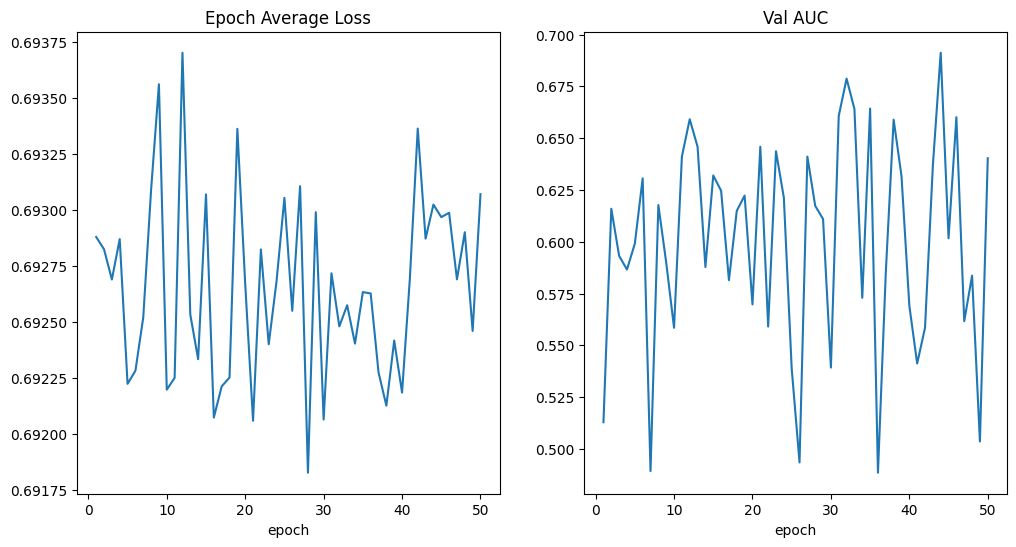

In [28]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

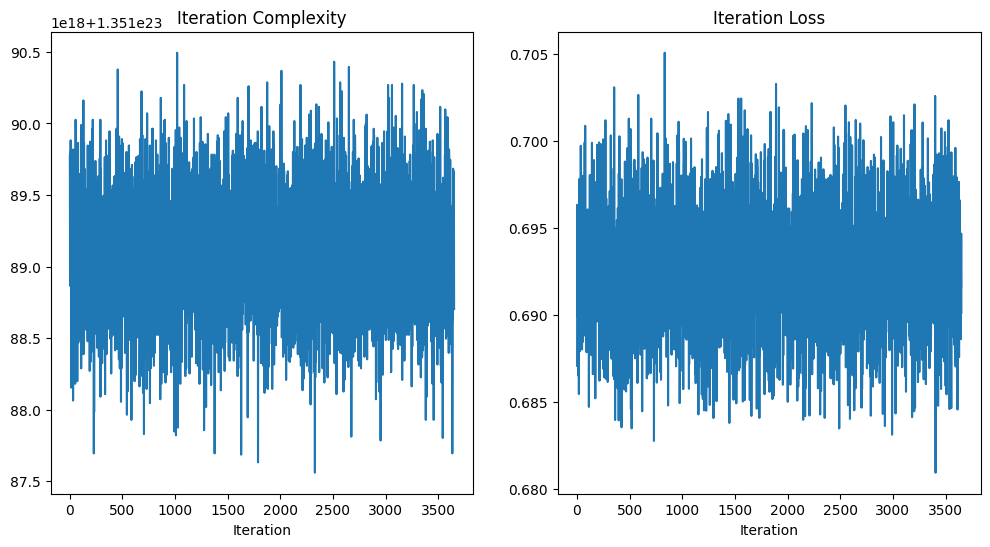

In [29]:
fig = plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Complexity")
x = [i + 1 for i in range(len(single_complexity))]
y = single_complexity
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Iteration Loss")
x = [val_interval * (i + 1) for i in range(len(single_loss))]
y = single_loss
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()
fig.savefig('complexity.png')


In [30]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [31]:
for i in y_true:
    if i == y_pred:
        print('True')
    else:
        print('False')

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
